In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
from stable_baselines3 import PPO

In [32]:
class CustomCheetahEnv(gym.Wrapper):    
    def __init__(self, env):
        super().__init__(env)
        self.step_count = 0
        self.max_steps = 100

        self.bad_behavior_cutoff = -50
        self.good_behavior_cutoff = 10
        self.current_episode_true_reward = 0
        self.current_episode_artificial_reward = 0
        
    def step(self, action):
        obs, true_reward, terminated, truncated, info = self.env.step(action)
        
        forward_reward = info.get("reward_forward", 0.0)  # Forward reward component
        ctrl_cost = info.get("reward_ctrl", 0.0)      # Control cost component
        bfoot_velocities = (abs(obs[4]), abs(obs[13]))
        artificial_reward = 0.7*forward_reward + ctrl_cost + np.mean(bfoot_velocities)
        self.current_episode_artificial_reward += artificial_reward
        self.current_episode_true_reward += true_reward
        
        # Increment step counter
        self.step_count += 1
        if self.step_count >= self.max_steps:
            truncated = True

        return obs, artificial_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.step_count = 0
        self.current_episode_true_reward = 0
        self.current_episode_artificial_reward = 0
        return self.env.reset(**kwargs)

In [18]:
def load_model(checkpoint_path):
    try:
        base_env = gym.make("HalfCheetah-v5")
        env = CustomCheetahEnv(base_env)
        model = PPO.load(checkpoint_path, env=env, device='cpu')
        return model, env
    except Exception as e:
        print(f"Error {e}")
        return None, None

In [ ]:
checkpoint_dir = "./hacky_cheetah_v1/checkpoints"
checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "*.zip")))
iterations = []
avg_trues = []
avg_artificials = []

for checkpoint_path in checkpoint_files:
    checkpoint_name = os.path.basename(checkpoint_path)
    print(f"Processing checkpoint: {checkpoint_name}")
    
    model, env = load_model(checkpoint_path)
    n_eval_episodes = 10
    true_rewards = []
    artificial_rewards = []

    for i in range(n_eval_episodes):
        obs, _ = env.reset()
        done = False
        env.current_episode_true_reward = 0
        env.current_episode_artificial_reward = 0
        
        step_count = 0
        max_steps = 1000
        
        while not done and step_count < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, artificial_reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step_count += 1
        
        # Get the true rewards that were accumulated in the environment
        episode_true_reward = env.current_episode_true_reward
        episode_artificial_reward = env.current_episode_artificial_reward
        
        true_rewards.append(episode_true_reward)
        artificial_rewards.append(episode_artificial_reward)
    
    avg_true = np.mean(true_rewards)
    avg_artificial = np.mean(artificial_rewards)
    
    iterations.append(checkpoint_name.split('_')[1])
    avg_trues.append(avg_true)
    avg_artificials.append(avg_artificial)

    

C:\Users\ronki\AppData\Local\Temp\ipykernel_20972\2907584533.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45)


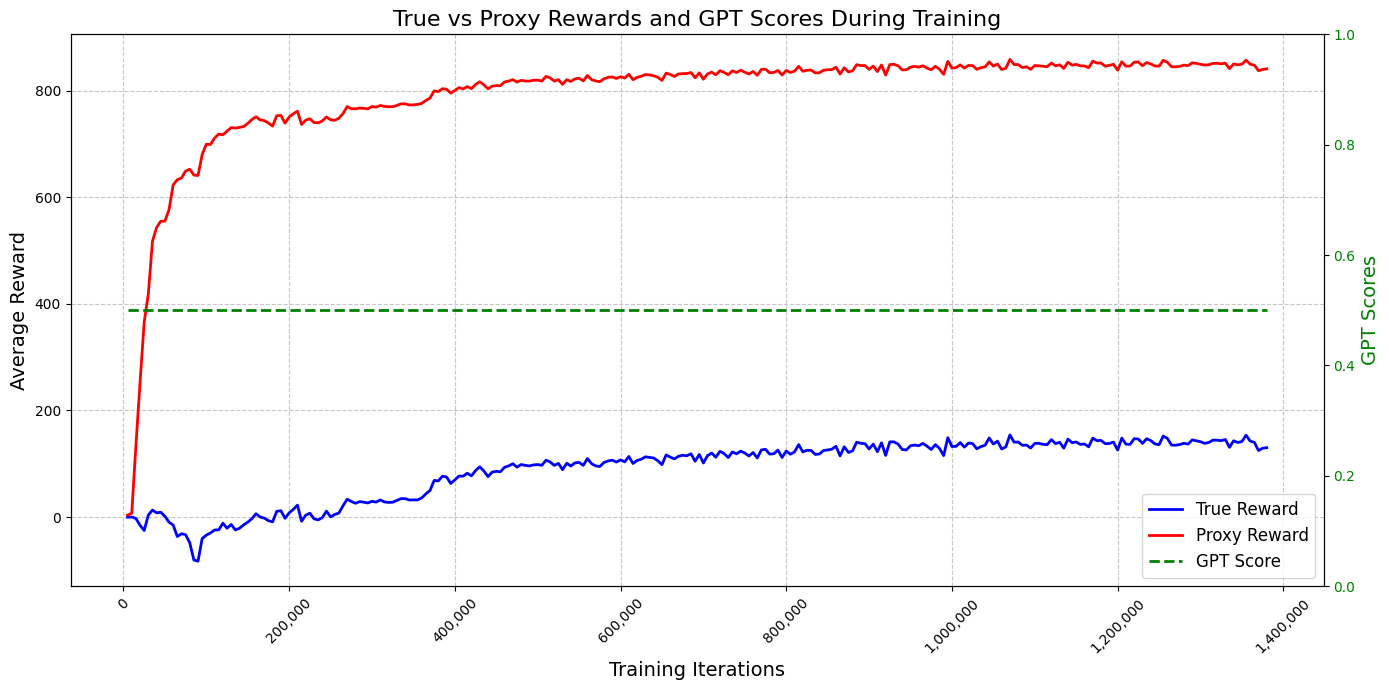

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Convert iterations from strings to integers
iterations_int = [int(it) for it in iterations]

# Sort the data by iteration number
sorted_indices = np.argsort(iterations_int)
iterations_sorted = [iterations_int[i] for i in sorted_indices]
true_rewards_sorted = [avg_trues[i] for i in sorted_indices]
proxy_rewards_sorted = [avg_artificials[i] for i in sorted_indices]

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot true and proxy rewards on the left y-axis
ax1.plot(iterations_sorted, true_rewards_sorted, label='True Reward', color='blue', linewidth=2)
ax1.plot(iterations_sorted, proxy_rewards_sorted, label='Proxy Reward', color='red', linewidth=2)
ax1.set_xlabel('Training Iterations', fontsize=14)
ax1.set_ylabel('Average Reward', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create the second y-axis for GPT scores
ax2 = ax1.twinx()
ax2.plot(iterations_sorted, [0.5] * len(iterations_sorted), label='GPT Score', color='green', linewidth=2, linestyle='--')
ax2.set_ylabel('GPT Scores', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)  # Set a reasonable range for GPT scores

# Add titles and legends
plt.title('True vs Proxy Rewards and GPT Scores During Training', fontsize=16)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

# Format x-axis
ax1.ticklabel_format(axis='x', style='plain')
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [70]:
class CustomCheetahGPTEnv(gym.Wrapper):    
    def __init__(self, env, gpt_score, alpha=1):
        super().__init__(env)
        self.step_count = 0
        self.max_steps = 100
        self.gpt_score = gpt_score
        print(gpt_score)
        self.alpha = alpha
        self.bad_behavior_cutoff = -5
        self.good_behavior_cutoff = 1
        self.current_episode_true_reward = 0
        self.current_episode_artificial_reward = 0
        
    def asym_logit(self, gpt_score):
        if gpt_score < 0.5:
            factor = -np.exp(self.bad_behavior_cutoff) / (np.exp(self.bad_behavior_cutoff) - 1)
            return np.log((gpt_score + factor) / (factor + 1 - gpt_score))
        else:
            factor = 1.0 / (np.exp(self.good_behavior_cutoff) - 1)
            return np.log((gpt_score + factor) / (factor + 1 - gpt_score))
        
    def step(self, action):
        obs, true_reward, terminated, truncated, info = self.env.step(action)
        
        forward_reward = info.get("reward_forward", 0.0)  # Forward reward component
        ctrl_cost = info.get("reward_ctrl", 0.0)      # Control cost component
        bfoot_velocities = (abs(obs[4]), abs(obs[13]))
        artificial_reward = 0.7*forward_reward + ctrl_cost + np.mean(bfoot_velocities)
        vlm_reward = self.asym_logit(self.gpt_score)
        artificial_reward += self.alpha*vlm_reward
        
        self.current_episode_artificial_reward += artificial_reward
        self.current_episode_true_reward += true_reward
        
        # Increment step counter
        self.step_count += 1
        if self.step_count >= self.max_steps:
            truncated = True
        

        return obs, artificial_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.step_count = 0
        self.current_episode_true_reward = 0
        self.current_episode_artificial_reward = 0
        return self.env.reset(**kwargs)

In [ ]:
import pandas as pd

output_dir = "./gpt_modif"
checkpoint_dir = os.path.join(output_dir, "checkpoints")
metrics_path = os.path.join(output_dir, "metrics", "training_metrics.csv")
metrics_df = pd.read_csv(metrics_path)
print(metrics_df.head())

checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "*.zip")))
iterations = []
avg_trues = []
avg_artificials = []
gpt_scores = []

for checkpoint_path in checkpoint_files:
    checkpoint_name = os.path.basename(checkpoint_path)
    print(f"Processing checkpoint: {checkpoint_name}")
    iter = int(checkpoint_name.split('_')[1])
    gpt_score = metrics_df.loc[metrics_df['timestep'] == iter, 'latest_gpt_score'].values[0]
    base_env = gym.make("HalfCheetah-v5")
    env = CustomCheetahGPTEnv(base_env, gpt_score)
    model = PPO.load(checkpoint_path, env=env, device='cpu')
    
    n_eval_episodes = 10
    true_rewards = []
    artificial_rewards = []

    for i in range(n_eval_episodes):
        obs, _ = env.reset()
        done = False
        env.current_episode_true_reward = 0
        env.current_episode_artificial_reward = 0
        
        step_count = 0
        max_steps = 1000
        
        while not done and step_count < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, artificial_reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step_count += 1
        
        # Get the true rewards that were accumulated in the environment
        episode_true_reward = env.current_episode_true_reward
        episode_artificial_reward = env.current_episode_artificial_reward
        
        true_rewards.append(episode_true_reward)
        artificial_rewards.append(episode_artificial_reward)
    
    avg_true = np.mean(true_rewards)
    avg_artificial = np.mean(artificial_rewards)
    
    iterations.append(checkpoint_name.split('_')[1])
    avg_trues.append(avg_true)
    avg_artificials.append(avg_artificial)
    gpt_scores.append(gpt_score)

    

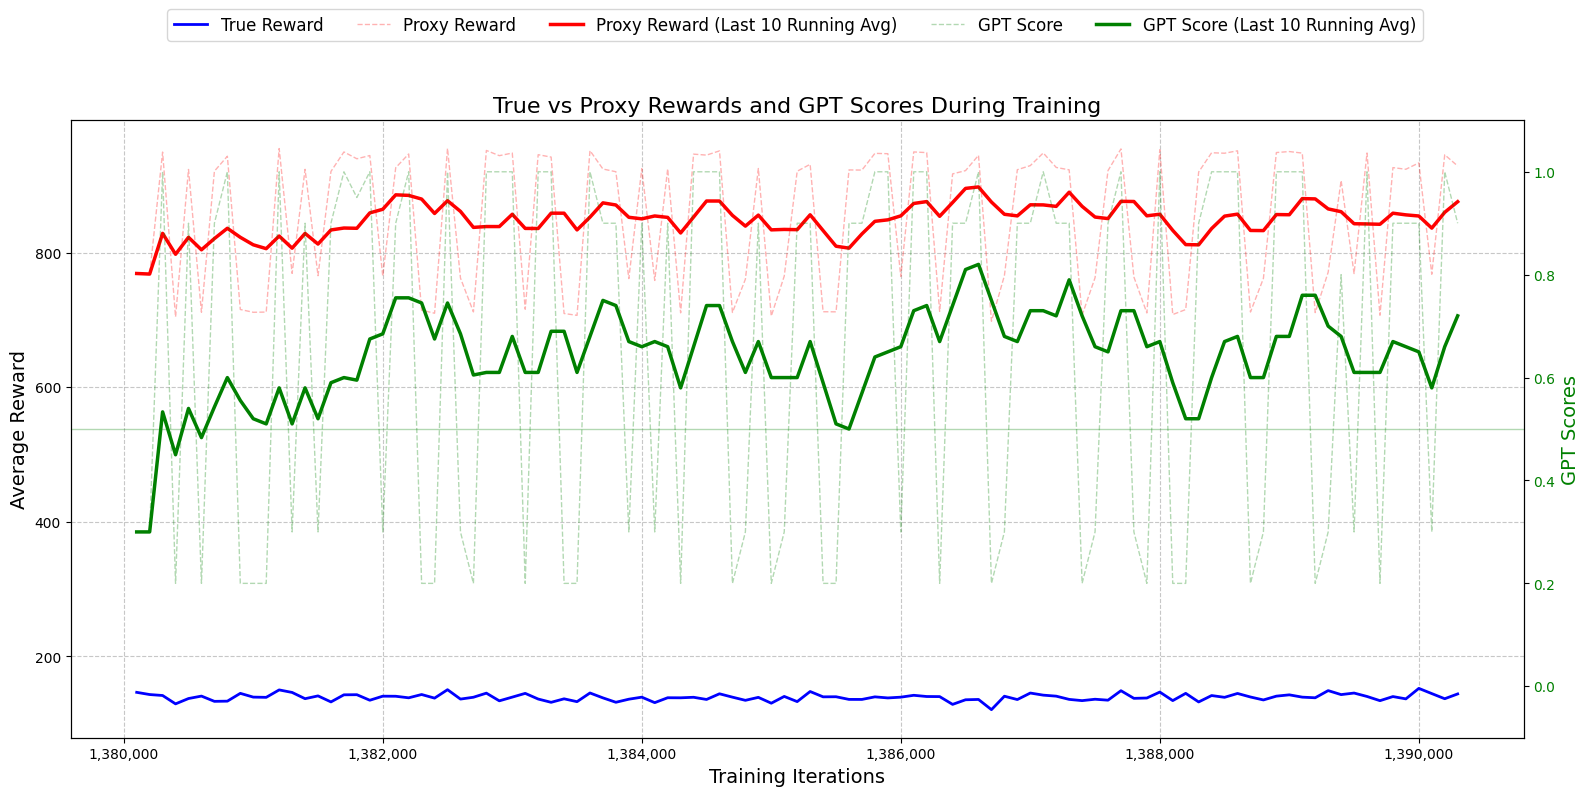

In [76]:
# Convert iterations from strings to integers (if they're not already)
iterations_int = [int(it) for it in iterations]

# Sort the data by iteration number
sorted_indices = np.argsort(iterations_int)
iterations_sorted = [iterations_int[i] for i in sorted_indices]
true_rewards_sorted = [avg_trues[i] for i in sorted_indices]
proxy_rewards_sorted = [avg_artificials[i] for i in sorted_indices]

# Get corresponding GPT scores for each iteration
gpt_scores = []
for iter_val in iterations_sorted:
    score = metrics_df.loc[metrics_df['timestep'] == iter_val, 'latest_gpt_score'].values
    if len(score) > 0:
        gpt_scores.append(score[0])
    else:
        # If no score is found, use NaN which matplotlib will skip when plotting
        gpt_scores.append(np.nan)

# Calculate running average of GPT scores
gpt_window_size = 10
gpt_scores_series = pd.Series(gpt_scores)
gpt_scores_running_avg = gpt_scores_series.rolling(window=gpt_window_size, min_periods=1).mean().values

# Calculate running average of proxy rewards
proxy_window_size = 10
proxy_rewards_series = pd.Series(proxy_rewards_sorted)
proxy_rewards_running_avg = proxy_rewards_series.rolling(window=proxy_window_size, min_periods=1).mean().values


# Create the plot with dual y-axes, increase figure size to accommodate legend outside
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot true and proxy rewards on the left y-axis
line1, = ax1.plot(iterations_sorted, true_rewards_sorted, label='True Reward', color='blue', linewidth=2)
line2, = ax1.plot(iterations_sorted, proxy_rewards_sorted, label='Proxy Reward', color='red', 
                  linewidth=1, linestyle='--', alpha=0.3)
line2_avg, = ax1.plot(iterations_sorted, proxy_rewards_running_avg, label='Proxy Reward (Running Avg)', 
                      color='red', linewidth=2.5, linestyle='-')

ax1.set_xlabel('Training Iterations', fontsize=14)
ax1.set_ylabel('Average Reward', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create the second y-axis for GPT scores
ax2 = ax1.twinx()

# Add reference line at GPT score 0.5 (midpoint)
ax2.axhline(y=0.5, color='green', linestyle='-', linewidth=1, alpha=0.3)

# Plot original GPT scores with fainter appearance
line3, = ax2.plot(iterations_sorted, gpt_scores, label='GPT Score', color='green', 
                 linewidth=1, linestyle='--', alpha=0.3)

# Plot running average with bolder appearance
line4, = ax2.plot(iterations_sorted, gpt_scores_running_avg, label='GPT Score (Running Avg)', 
                 color='green', linewidth=2.5, linestyle='-')

ax2.set_ylabel('GPT Scores', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(-0.1, 1.1)  # Set reasonable range for GPT scores

# Add title
plt.title('True vs Proxy Rewards and GPT Scores During Training', fontsize=16)

fig.legend(
    [line1, line2, line2_avg, line3, line4], 
    ['True Reward', 'Proxy Reward', f'Proxy Reward (Last {proxy_window_size} Running Avg)', 
     'GPT Score', f'GPT Score (Last {gpt_window_size} Running Avg)'],
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.0), 
    ncol=5,
    fontsize=12
)

# Format x-axis to show fewer ticks for readability
ax1.ticklabel_format(axis='x', style='plain')
plt.xticks(rotation=45)

# Add a thousand separator for the x-axis labels
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to make room for the legend
plt.subplots_adjust(top=0.85)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()